## Load the environment

---

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from agent import DLQAgent
from datetime import datetime
import sys
import json
import matplotlib.pyplot as plt
from operator import itemgetter
%matplotlib inline

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="../Banana.app")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Create an agent evaluation method

---

In [3]:
def rolling_avg_scores(scores, window):
    if len(scores) <= window:
        return [np.mean(scores)]
    else:
        return [np.mean(scores[x:x+window]) for x in range(len(scores) - window + 1)]

def run(env, brain_name, agent, num_episodes=1500):
    start_time = datetime.utcnow()
    scores = []
    health_checks = []
    for i_episode in range(num_episodes):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        while True:
            action = agent.act(state)                      # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score
            agent.step(
                state, action, next_state, reward, done)   # update the agent
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                scores.append(score)
                break
        health_check = agent.health_check()
        health_checks.append(health_check)
        model1_loss, memory_max_prioritization, memory_size = health_check
        print("\rEpisode %d/%d | Max Average Score: %.2f | Model 1 loss: %.2f | Memory max prioritization: %.2f | Memory size: %d   " % (
            i_episode,
            num_episodes,
            max(rolling_avg_scores(scores, 20)),
            model1_loss,
            memory_max_prioritization,
            memory_size), end="")
        sys.stdout.flush()
    end_time = datetime.utcnow()
    return scores, end_time - start_time, health_checks

def evaluate_agent(env, brain_name, agent):
    scores, run_timing, health_checks = run(env, brain_name, agent, num_episodes=agent.num_episodes)
    with open('training_log.txt', 'a') as file:
        file.write("Training run on %s \n" % datetime.utcnow().isoformat())
        file.write("Lasted %dmin%d \n" % (run_timing.seconds // 60, run_timing.seconds % 60))
        file.write(json.dumps(Config().as_dict(), indent=2))
        file.write("\nMax average score: %f\n\n" % max(rolling_avg_scores(scores, 20)))
    plt.plot(np.arange(len(scores)), scores)
    plt.plot(np.arange(19, len(scores)), rolling_avg_scores(scores, 20))
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    losses = [x for x in map(itemgetter(0), health_checks)]
    plt.plot(np.arange(len(losses)), losses)
    plt.plot(np.arange(19, len(losses)), rolling_avg_scores(losses, 20))
    plt.ylabel('Loss')
    plt.xlabel('Episode #')
    plt.show()
    print("Max avg over 100 episodes window: %d" % max(rolling_avg_scores(scores, 100)))
    return scores

## Evaluate Vanila DQN agent

---

Episode 499/500 | Max Average Score: 15.85 | Model 1 loss: 0.10 | Memory max prioritization: 1.00 | Memory size: 100000   

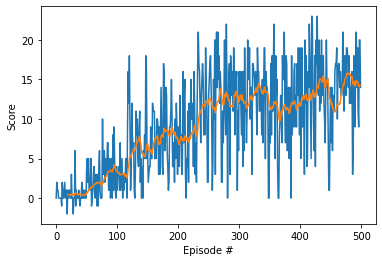

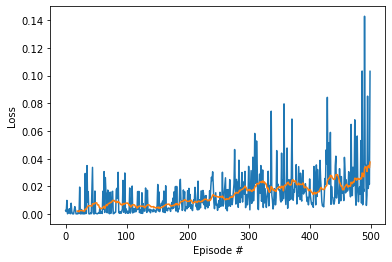

Max avg over 100 episodes window: 13


In [4]:
class Config:
    def __init__(self):
        self.num_episodes = 500
        self.gamma = 0.99
        self.epsilon = 0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0
        self.tau = 1e-3
        self.memory_size = int(1e5)
        self.batch_size = 64
        self.update_every = 4
        self.mlp_layers = (200, 150, 150)
        self.learning_rate = 5e-4

        self.is_ddqn = False
        
        self.is_dueling = False
        
        self.is_prioritization = False
        
        self.is_distributional = False        
        
    def as_dict(self):
        return self.__dict__

env_info = env.reset(train_mode=True)[brain_name]
vanilla_dqn_agent = DLQAgent(Config(), brain.vector_action_space_size, len(env_info.vector_observations[0]))

vanilla_dqn_scores = evaluate_agent(env, brain_name, vanilla_dqn_agent)

## Evaluate Double DQN agent

---

Episode 499/500 | Max Average Score: 17.90 | Model 1 loss: 0.01 | Memory max prioritization: 1.00 | Memory size: 100000   

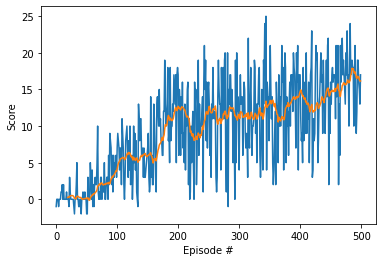

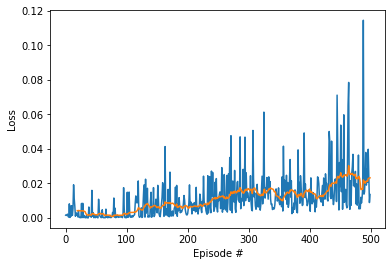

Max avg over 100 episodes window: 14


In [5]:
class Config:
    def __init__(self):
        self.num_episodes = 500
        self.gamma = 0.99
        self.epsilon = 0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0
        self.tau = 1e-3
        self.memory_size = int(1e5)
        self.batch_size = 64
        self.update_every = 4
        self.mlp_layers = (200, 150, 150)
        self.learning_rate = 5e-4

        self.is_ddqn = True
        
        self.is_dueling = False
        
        self.is_prioritization = False
        
        self.is_distributional = False
        
        
    def as_dict(self):
        return self.__dict__

env_info = env.reset(train_mode=True)[brain_name]
ddqn_agent = DLQAgent(Config(), brain.vector_action_space_size, len(env_info.vector_observations[0]))

ddqn_scores = evaluate_agent(env, brain_name, ddqn_agent)

## Evaluate dueling DQN agent

---

Episode 499/500 | Max Average Score: 12.35 | Model 1 loss: 0.02 | Memory max prioritization: 1.00 | Memory size: 100000   

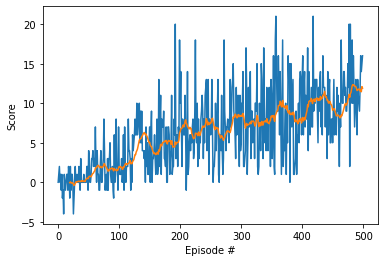

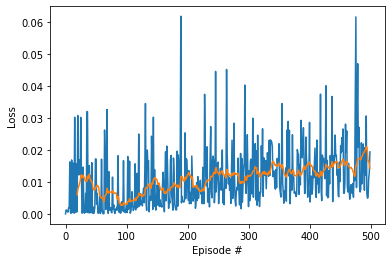

Max avg over 100 episodes window: 10


In [6]:
class Config:
    def __init__(self):
        self.num_episodes = 500
        self.gamma = 0.99
        self.epsilon = 0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0
        self.tau = 1e-3
        self.memory_size = int(1e5)
        self.batch_size = 64
        self.update_every = 4
        self.mlp_layers = (200, 150, 150)
        self.learning_rate = 5e-4

        self.is_ddqn = False
        
        self.is_dueling = True
        
        self.is_prioritization = False
        
        self.is_distributional = False
        
        
    def as_dict(self):
        return self.__dict__

env_info = env.reset(train_mode=True)[brain_name]
dueling_dqn_agent = DLQAgent(Config(), brain.vector_action_space_size, len(env_info.vector_observations[0]))

dueling_dqn_scores = evaluate_agent(env, brain_name, dueling_dqn_agent)

## Evaluate prioritized replay DQN agent

---

Episode 499/500 | Max Average Score: 12.70 | Model 1 loss: 0.01 | Memory max prioritization: 2.45 | Memory size: 100000   

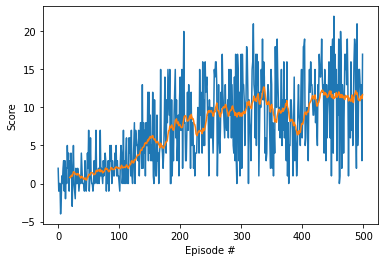

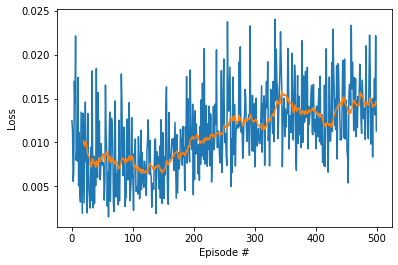

Max avg over 100 episodes window: 11


In [7]:
class Config:
    def __init__(self):
        self.num_episodes = 500
        self.gamma = 0.99
        self.epsilon = 0
        self.epsilon_decay = 1
        self.epsilon_min = 0
        self.tau = 1e-3
        self.memory_size = int(1e5)
        self.batch_size = 64
        self.update_every = 4
        self.mlp_layers = (200, 150, 150)
        self.learning_rate = 5e-4

        self.is_ddqn = True
        
        self.is_dueling = False
        
        self.is_prioritization = True
        self.min_prioritization = 1e-2
        self.prioritization_exponent = 0.5
        self.prioritization_importance_sampling_start = 0.4
        self.prioritization_importance_sampling_end = 1
        
        self.is_distributional = False
        
        
    def as_dict(self):
        return self.__dict__

env_info = env.reset(train_mode=True)[brain_name]
prioritized_dqn_agent = DLQAgent(Config(), brain.vector_action_space_size, len(env_info.vector_observations[0]))

prioritized_dqn_scores = evaluate_agent(env, brain_name, prioritized_dqn_agent)

## Evaluate distributional DQN agent

---

Episode 499/500 | Max Average Score: 14.75 | Model 1 loss: 3.63 | Memory max prioritization: 1.00 | Memory size: 100000   

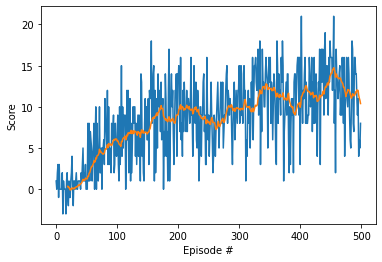

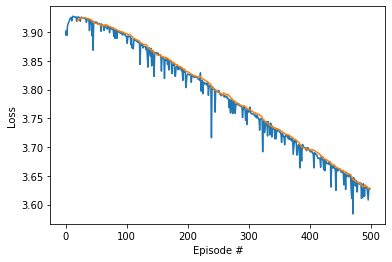

Max avg over 100 episodes window: 12


In [8]:
class Config:
    def __init__(self):
        self.num_episodes = 500
        self.gamma = 0.99
        self.epsilon = 0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0
        self.tau = 1e-3
        self.memory_size = int(1e5)
        self.batch_size = 64
        self.update_every = 4
        self.mlp_layers = (200, 150)
        self.learning_rate = 5e-4

        self.is_ddqn = False
        
        self.is_dueling = False
        
        self.is_prioritization = False
        
        self.is_distributional = True
        self.distributional_n = 51
        self.distributional_min = -20
        self.distributional_max = 20
        
        
    def as_dict(self):
        return self.__dict__

env_info = env.reset(train_mode=True)[brain_name]
distributional_dqn_agent = DLQAgent(Config(), brain.vector_action_space_size, len(env_info.vector_observations[0]))

distributional_dqn_scores = evaluate_agent(env, brain_name, distributional_dqn_agent)

## Evaluate combined DQN agent

---

Episode 499/500 | Max Average Score: 13.20 | Model 1 loss: 3.54 | Memory max prioritization: 2.84 | Memory size: 100000   

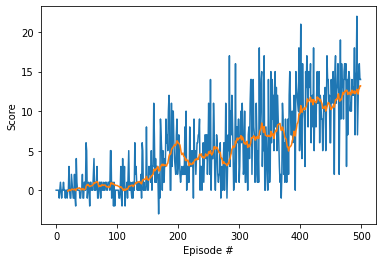

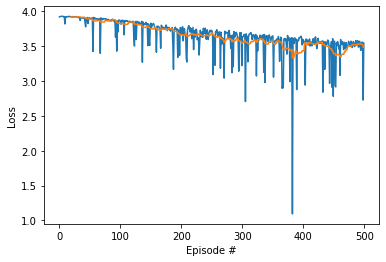

Max avg over 100 episodes window: 11


In [9]:
class Config:
    def __init__(self):
        self.num_episodes = 500
        self.gamma = 0.99
        self.epsilon = 0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0
        self.tau = 1e-3
        self.memory_size = int(1e5)
        self.batch_size = 64
        self.update_every = 4
        self.mlp_layers = (200, 150, 150)
        self.learning_rate = 5e-4

        self.is_ddqn = True
        
        self.is_dueling = True
        
        self.is_prioritization = True
        self.min_prioritization = 1e-2
        self.prioritization_exponent = 0.5
        self.prioritization_importance_sampling_start = 0.4
        self.prioritization_importance_sampling_end = 1
        
        self.is_distributional = True
        self.distributional_n = 51
        self.distributional_min = -20
        self.distributional_max = 20
        
        
    def as_dict(self):
        return self.__dict__

env_info = env.reset(train_mode=True)[brain_name]
combined_dqn_agent = DLQAgent(Config(), brain.vector_action_space_size, len(env_info.vector_observations[0]))

combined_dqn_scores = evaluate_agent(env, brain_name, combined_dqn_agent)

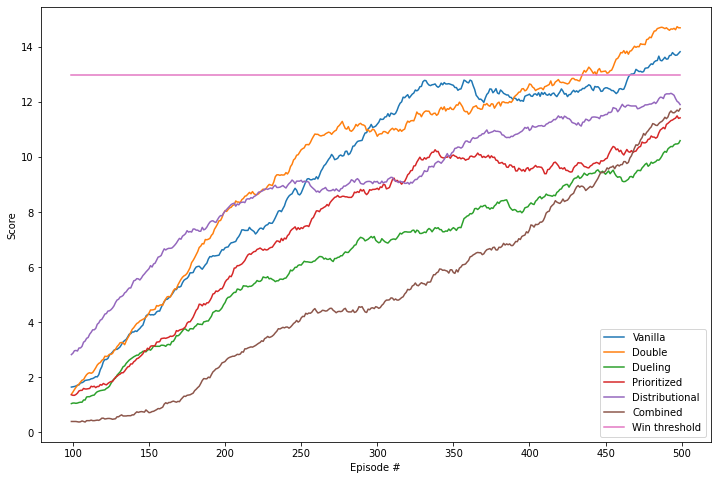

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(np.arange(99, len(vanilla_dqn_scores)), rolling_avg_scores(vanilla_dqn_scores, 100), label='Vanilla')
plt.plot(np.arange(99, len(ddqn_scores)), rolling_avg_scores(ddqn_scores, 100), label='Double')
plt.plot(np.arange(99, len(dueling_dqn_scores)), rolling_avg_scores(dueling_dqn_scores, 100), label='Dueling')
plt.plot(np.arange(99, len(prioritized_dqn_scores)), rolling_avg_scores(prioritized_dqn_scores, 100), label='Prioritized')
plt.plot(np.arange(99, len(distributional_dqn_scores)), rolling_avg_scores(distributional_dqn_scores, 100), label='Distributional')
plt.plot(np.arange(99, len(combined_dqn_scores)), rolling_avg_scores(combined_dqn_scores, 100), label='Combined')
plt.plot(np.arange(99, len(combined_dqn_scores)), np.ones(401) * 13, label='Win threshold')
plt.ylabel('Score')
plt.xlabel('Episode #')
ax.legend()
plt.show()